<a href="https://colab.research.google.com/github/Aleena24/real-image-SRGAN/blob/main/research_srgan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import glob
import os
import time
import cv2

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras import Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [21]:
def residual_block(x):
    """`
    Residual block
    """
    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size,
                 strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size,
                 strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    # Add res and x
    res = Add()([res, x])
    return res

In [22]:
#Generator Network
def build_generator(gen_input):
    """
    Create a generator network using the hyperparameter values defined below
    :return:
    """
    residual_blocks = 16
    momentum = 0.8
    # Input Layer of the generator network
    input_layer = gen_input

    # Add the pre-residual block
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same',
                  activation='relu')(input_layer)

    # Add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)

    # Add the post-residual block
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)

    # Take the sum of the output from the pre-residual block(gen1) and the post-residual block(gen2)
    gen3 = Add()([gen2, gen1])

    # Add an upsampling block
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)

    # Add another upsampling block
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1,
                  padding='same')(gen5)
    gen5 = Activation('relu')(gen5)

    # Output convolution layer
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)

    # Keras model
    model = Model(inputs=[input_layer], outputs=[output],
                  name='generator')
    return model

In [23]:
def build_discriminator(dis_input):
    """
    Create a discriminator network using the hyperparameter values defined below
    :return:
    """
    leakyrelu_alpha = 0.2
    momentum = 0.8

    input_layer = dis_input

    # Add the first convolution block
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    # Add the 2nd convolution block
    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    # Add the third convolution block
    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    # Add the fourth convolution block
    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    # Add the fifth convolution block
    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    # Add the sixth convolution block
    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    # Add the seventh convolution block
    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    # Add the eight convolution block
    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)

    # Add a dense layer
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)

    # Last dense layer - for classification
    output = Dense(units=1, activation='sigmoid')(dis9)

    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    return model

In [24]:
def build_adversarial_model(generator, discriminator, vgg):

    input_low_resolution = Input(shape=(64, 64, 3))

    fake_hr_images = generator(input_low_resolution)
    fake_features = vgg(fake_hr_images)

    discriminator.trainable = False

    output = discriminator(fake_hr_images)

    model = Model(inputs=[input_low_resolution],
                  outputs=[output, fake_features])

    for layer in model.layers:
        print(layer.name, layer.trainable)

    return model

In [26]:
def build_vgg(high_resolution_shape):
    vgg = VGG19(weights = 'imagenet', include_top=False, input_shape=high_resolution_shape)

    return Model(inputs = vgg.inputs, outputs = vgg.layers[10].output)

def create_combination(generator,discriminator,vgg,input_low_resolution,input_high_resolution):
    generated_high_resolution_images = generator(input_low_resolution)

    features = vgg(generated_high_resolution_images)

    discriminator.trainable = False

    probs = discriminator(generated_high_resolution_images)

    adversarial_model = Model(inputs=[input_low_resolution, input_high_resolution], outputs=[probs, features])

    return adversarial_model

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np

n = 100
lr_images = []
hr_images = []

lr_dir = "/content/drive/MyDrive/research_dataset/BSD100"
hr_dir = "/content/drive/MyDrive/research_dataset/BSD100"

common_width = 256
common_height = 256

def resize_image(image, width, height):
    return cv2.resize(image, (width, height))

for img_name in os.listdir(lr_dir)[:n]:
    img_path = os.path.join(lr_dir, img_name)
    img_lr = cv2.imread(img_path)
    if img_lr is not None:
        img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
        img_lr = resize_image(img_lr, common_width, common_height)
        lr_images.append(img_lr)
        print("LR image shape:", img_lr.shape)
    else:
        print(f"Failed to read image: {img_path}")

for img_name in os.listdir(hr_dir)[:n]:
    img_path = os.path.join(hr_dir, img_name)
    img_hr = cv2.imread(img_path)
    if img_hr is not None:
        img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
        img_hr = resize_image(img_hr, common_width, common_height)
        hr_images.append(img_hr)
        print("HR image shape:", img_hr.shape)
    else:
        print(f"Failed to read image: {img_path}")

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

print("Low-resolution images shape:", lr_images.shape)
print("High-resolution images shape:", hr_images.shape)


<ipython-input-30-61f543aa3bd8>:12: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  upscaled_lr_image = rescale(lr_images[image_number], scale=4, mode='constant', multichannel=True, anti_aliasing=True)


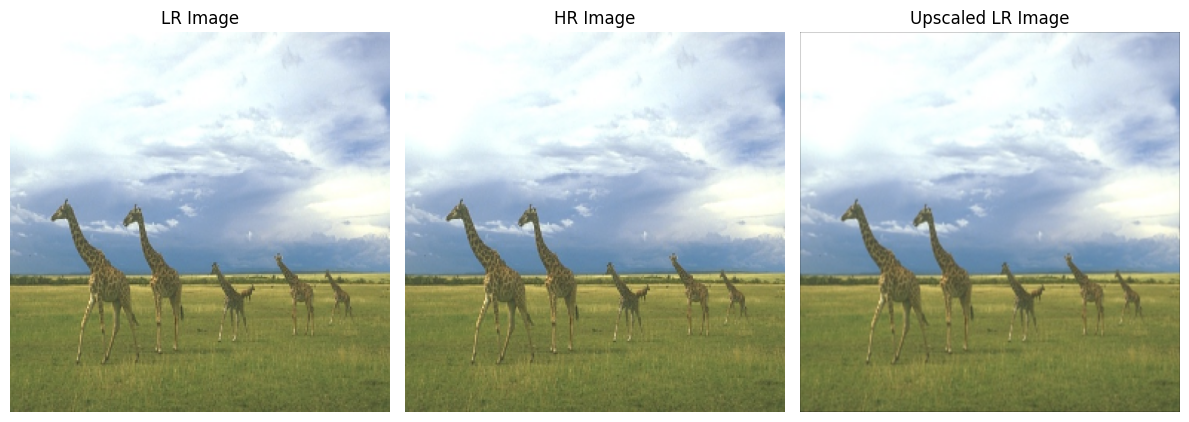

In [30]:
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import rescale

# Assuming lr_images and hr_images are your LR and HR image datasets, respectively

# Randomly select an image number
image_number = random.randint(0, len(lr_images) - 1)

# Upscale the LR image using bicubic interpolation
upscaled_lr_image = rescale(lr_images[image_number], scale=4, mode='constant', multichannel=True, anti_aliasing=True)

# Set up the figure
plt.figure(figsize=(12, 6))

# Display LR image
plt.subplot(131)
plt.title('LR Image')
plt.imshow(lr_images[image_number])
plt.axis('off')

# Display HR image
plt.subplot(132)
plt.title('HR Image')
plt.imshow(hr_images[image_number])
plt.axis('off')

# Display Upscaled LR image
plt.subplot(133)
plt.title('Upscaled LR Image')
plt.imshow(upscaled_lr_image)
plt.axis('off')

plt.tight_layout()
plt.show()


In [31]:
#Scale values
lr_images = lr_images/255
hr_images = hr_images/255

In [32]:
#Train test Split
from sklearn.model_selection import train_test_split

lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images,hr_images,test_size=0.3,random_state=100)

low_resolution_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])
high_resolution_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])

In [33]:
# Shape of low-resolution and high-resolution images
input_low_resolution = Input(shape=low_resolution_shape)
input_high_resolution = Input(shape=high_resolution_shape)

In [ ]:
generator = build_generator(input_low_resolution)
generator.summary()

In [ ]:
# Common optimizer for all networks
common_optimizer = Adam(0.0002, 0.5)
discriminator = build_discriminator(input_high_resolution)
discriminator.compile(loss='mse', optimizer=common_optimizer,
                      metrics=['accuracy'])
discriminator.summary()

In [ ]:
vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

In [ ]:
gan_model = create_combination(generator,discriminator,vgg,input_low_resolution,input_high_resolution)
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3, 1],
                  optimizer=common_optimizer)
gan_model.summary()

In [ ]:
adv_model = build_adversarial_model(generator,discriminator,vgg)
adv_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3, 1],
                  optimizer=common_optimizer)
adv_model.summary()

In [4]:
from tqdm import tqdm
import numpy as np

# Define the number of epochs and batch size
epochs = 100
batch_size = 8

# Assuming hr_train and lr_train are your HR and LR image datasets, respectively
# Placeholder for defining hr_train and lr_train
hr_train = np.array(...)  # Define or load your HR image dataset
lr_train = np.array(...)  # Define or load your LR image dataset

# Check the shapes of hr_train and lr_train
print("Shape of hr_train:", hr_train.shape)
print("Shape of lr_train:", lr_train.shape)

# Initialize empty lists to store training batches
train_lr_batches = []
train_hr_batches = []

# Divide the datasets into batches
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

# Training loop
for e in range(epochs):
    fake_label = np.zeros((batch_size, 1))  # Assign a label of 0 to all fake generated images
    real_label = np.ones((batch_size, 1))  # Assign a label of 1 to all real images

    # Lists for losses of generator and discriminator
    gen_losses = []
    dis_losses = []

    # Iterate over training batches
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]

        # Generate fake images
        fake_imgs = generator.predict_on_batch(lr_imgs)

        # Train discriminator
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        discriminator.trainable = False
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)

        # Predict image features
        image_features = vgg.predict(hr_imgs)

        # Save losses to a list
        dis_losses.append(d_loss)

    # Calculate average losses
    dis_losses = np.array(dis_losses)
    d_loss = np.sum(dis_losses, axis=0) / len(dis_losses)

    # Report the progress during training
    print("Epoch:", e+1, "Discriminator Loss:", d_loss)

    # Save the generator model after every n epochs
    if (e+1) % 10 == 0:
        generator.save("gen_e_" + str(e+1) + ".h5")


NameError: name 'hr_images' is not defined

In [ ]:
###################################################################################
#Test - perform super resolution using saved generator model
from tensorflow.keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_10.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


################################################
sreeni_lr = cv2.imread("data/sreeni_32.jpg")
sreeni_hr = cv2.imread("data/sreeni_256.jpg")

#Change images from BGR to RGB for plotting.
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()